<a href="https://colab.research.google.com/github/nidhi-059/Region-captioning-on-images-using-dl/blob/main/Task3_part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision import datasets

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)

In [3]:
# Transform: convert to tensor and normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # mean and std for MNIST
])

# Download and load the training data
train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    transform=transform,
    download=True
)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 485kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.63MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.87MB/s]


In [8]:
loss_func = nn.CrossEntropyLoss()

In [9]:
epochs = 30
learning_rate = 0.001

In [10]:
class AlexNetMNIST(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 192, 3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(192, 384, 3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(2, 2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 3 * 3, 1024),  # reduce FC size for speed
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [7]:
model1 = AlexNetMNIST(10)
model1 = model1.to(device)
losses = []
accuracy = []
optimizer = torch.optim.Adam(model1.parameters(),lr=learning_rate , weight_decay= 1e-4)
for epoch in range(epochs):
    total_labels = 0
    running_acc = 0.0
    running_loss = 0.0
    for batch_features, batch_labels in train_loader:
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

        #forward pass
        y_predic = model1(batch_features)
        #calcuting loss
        loss = loss_func(y_predic , batch_labels)
        #clearing grads
        optimizer.zero_grad()
        #backward pass
        loss.backward()
        #updating parameters
        optimizer.step()
        _, predicted = torch.max(y_predic, dim=1)
        running_acc += (predicted == batch_labels).sum().item()
        total_labels += batch_labels.size(0)
        running_loss += loss.item()

    # Compute epoch accuracy
    avg_loss = running_loss / (len(train_loader))
    avg_acc = running_acc / total_labels
    losses.append(avg_loss)
    accuracy.append(avg_acc)

    print(f"Epoch {epoch + 1}, Loss: {avg_loss:.6f},")


Epoch 1, Loss: 0.151641,
Epoch 2, Loss: 0.062814,
Epoch 3, Loss: 0.057996,
Epoch 4, Loss: 0.053157,
Epoch 5, Loss: 0.049746,
Epoch 6, Loss: 0.045565,
Epoch 7, Loss: 0.043680,
Epoch 8, Loss: 0.039416,
Epoch 9, Loss: 0.035831,
Epoch 10, Loss: 0.033986,
Epoch 11, Loss: 0.031042,
Epoch 12, Loss: 0.030849,
Epoch 13, Loss: 0.026656,
Epoch 14, Loss: 0.026068,
Epoch 15, Loss: 0.024075,
Epoch 16, Loss: 0.023172,
Epoch 17, Loss: 0.021676,
Epoch 18, Loss: 0.021814,
Epoch 19, Loss: 0.021395,
Epoch 20, Loss: 0.019890,
Epoch 21, Loss: 0.019339,
Epoch 22, Loss: 0.019134,
Epoch 23, Loss: 0.020457,
Epoch 24, Loss: 0.017697,
Epoch 25, Loss: 0.017606,
Epoch 26, Loss: 0.017196,
Epoch 27, Loss: 0.018126,
Epoch 28, Loss: 0.015035,
Epoch 29, Loss: 0.016045,
Epoch 30, Loss: 0.015870,


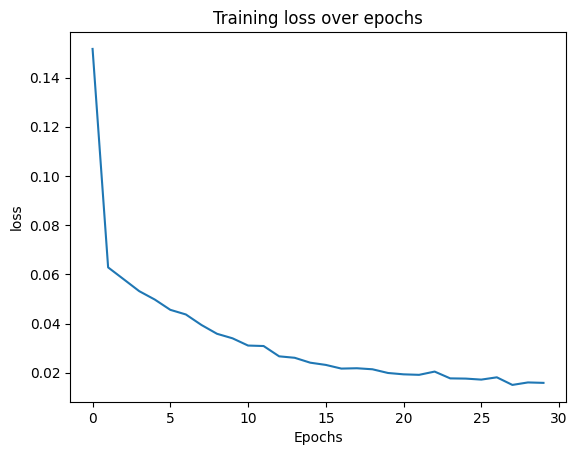

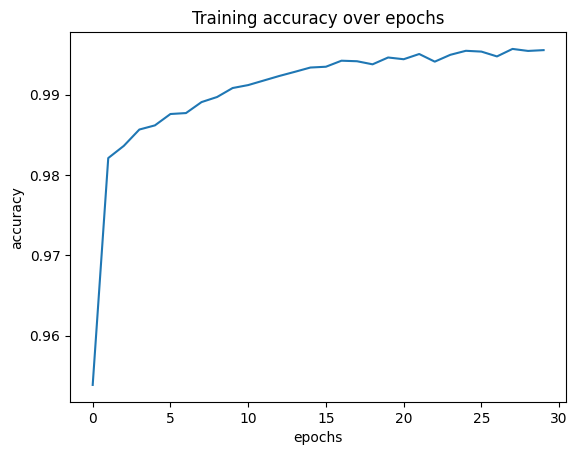

In [11]:
plt.plot(losses)
plt.title("Training loss over epochs")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.grid(False)
plt.show()
plt.plot(accuracy)
plt.title("Training accuracy over epochs")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.grid(False)
plt.show()

In [12]:
#Model evaluation
model1.eval()
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in test_loader:
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
    outputs = model1(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(f"Test accuracy: {(correct/total)*100}%")

Test accuracy: 99.19%


In [13]:
#Model evaluation

total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in train_loader:
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
    outputs = model1(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(f"Train accuracy : {(correct/total)*100}%")

Train accuracy : 99.82833333333333%


In [18]:
import numpy as np
classes = ['0','1','2','3','4','5','6','7','8','9']

def unnormalize(img_tensor):

    mean = 0.1307
    std = 0.3081
    img_tensor = img_tensor.clone()
    img_tensor = img_tensor * std + mean   # Undo normalization
    return img_tensor

def predict(model, image, transform=None, device='cpu'):
    model.to(device)
    model.eval()

    if transform is not None:
        image = transform(image)

    image = image.to(device)
    image_batch = image.unsqueeze(0)  # Add batch dimension

    with torch.no_grad():
        outputs = model(image_batch)
        _, predicted = torch.max(outputs, 1)

    predicted_label = classes[predicted.item()]

    # Unnormalize for display
    image_display = unnormalize(image.cpu())
    image_np = np.transpose(image_display.numpy(), (1, 2, 0))

    plt.imshow(image_np)
    plt.title(f'Predicted: {predicted_label}')
    plt.axis('off')
    plt.show()

    return predicted_label

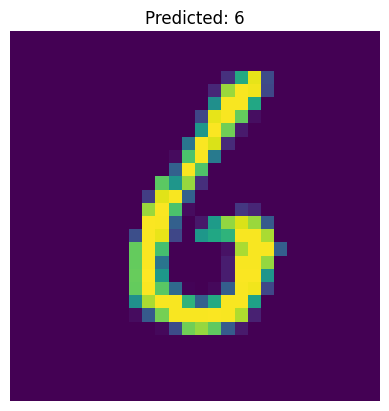

Actual: 6


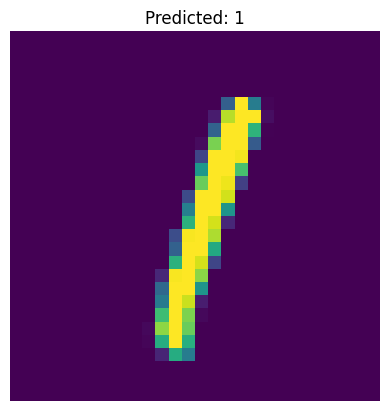

Actual: 1


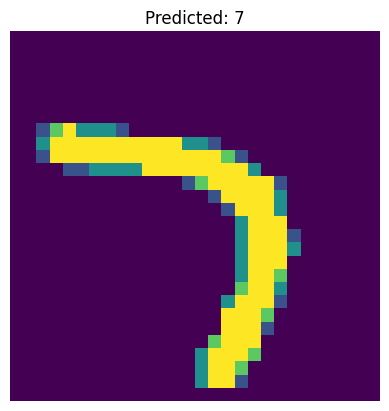

Actual: 7


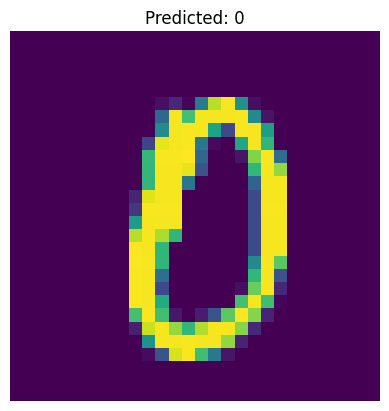

Actual: 0


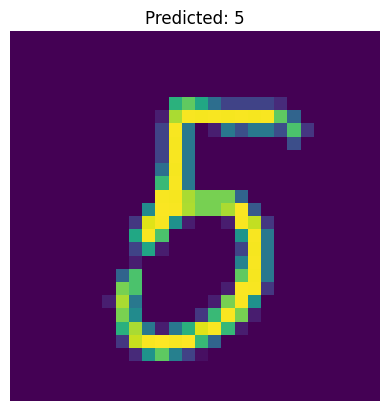

Actual: 5


In [21]:
data_iter = iter(test_loader)
images, labels = next(data_iter)


image = images[50]
label = labels[50]

# Predict
predicted_label = predict(model1, image, transform=None, device=device)
print(f'Actual: {classes[label]}')

image = images[5]
label = labels[5]

# Predict
predicted_label = predict(model1, image, transform=None, device=device)
print(f'Actual: {classes[label]}')

image = images[60]
label = labels[60]

# Predict
predicted_label = predict(model1, image, transform=None, device=device)
print(f'Actual: {classes[label]}')

image = images[55]
label = labels[55]

# Predict
predicted_label = predict(model1, image, transform=None, device=device)
print(f'Actual: {classes[label]}')

image = images[45]
label = labels[45]

# Predict
predicted_label = predict(model1, image, transform=None, device=device)
print(f'Actual: {classes[label]}')